TO Do
- Check value fresolution

In [3]:
import os
import sys
#sys.path.append(r'C:\Users\dpoppema\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05')
sys.path.append(r'E:\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05')
import puv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr


In [4]:
# input specification
instrFile = r"O:\HybridDune experiment\data ADV, OBS\QC\ADV S1ADV1 QC - period 1, 20mins cor60.nc"
ncOutFile = r"O:\HybridDune experiment\data ADV, OBS\processed\ADV S1ADV1 Processed data - period 1, 20mins cor60.nc"

# Ensure the input file exists
if not os.path.exists(instrFile):
    raise FileNotFoundError(f"The input file does not exist: {instrFile}")

# Ensure the output directory exists
out_dir = os.path.dirname(ncOutFile)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
     
# frequency resolution in fourier space
fresolution = 0.03125
#number of directional bins 
ntheta = 64
  
# load the raw data from netcdf
ds0 = xr.open_dataset(instrFile)


In [5]:
# INTERPOLATE NANS IN VARIABLES
# For variables with t, N dimension. block-avgs don't need interpolation. NB: Concentration (C_OBShigh, C_OBSlow) are skipped here, they need special treatment to deal with clipping (S3.ADV2 at least, the others don't clip during otherwise valid ADV data collection)
for var in ['u', 'v', 'w', 'pc', 'eta']:                      
    # interpolate the bursts where there is less than 50% nans
    data = ds0[var].where(                                  
        np.isnan(ds0[var]).sum(dim='N') < 0.5 * len(ds0.N)    # first make bursts with >50% nan completely nan
        ).dropna(dim='t', how='all')                          # then drop bursts with all nans
    
    # if any burst remaining, fill gaps less than 4 seconds with cubic interpolation
    if len(data.t) != 0:                                    
        ds0[var] = data.interpolate_na(
            dim='N', method='cubic', max_gap=4)               # NB: gap width in seconds, not in number of samples

    # and fill the gaps more than 4 in length with the burst average
    ds0[var] = ds0[var].fillna(ds0[var].mean(dim='N'))

# Ensure no NaNs or infs are present
#for var in ['u', 'v', 'w', 'pc', 'eta']:                             # For the interpolated variables,
#    ds0[var] = ds0[var].fillna(0).where(np.isfinite(ds0[var]), 0)    # make blocks that are 100% nan (from code above) all zeros
#ds0 = ds0.dropna(dim='t')                                           # alternative: simply drop blocks. NB: this only works if the concentration is interpolated, otherwise those nans cause all blocks to be dropped. 
ds0 = ds0.dropna(dim='t', subset=['u'])

In [6]:
# MAKE A NEW DATASET WITH EXTRA DIMENSION FOR FREQUENCY, DIRECTION, DETERMINE zi AND zb PER BLOCK 
# make a new dataset that has an extra dimension to accommodate for the frequency axis ===========================================
ds = xr.Dataset(data_vars={},
          coords = {'t': ds0.t.values,
                    'N': ds0.N.values,
                    'f': np.arange(0, ds0.sf.values/2, fresolution),
                    'theta': np.arange(start=-np.pi, stop=np.pi, step=2*np.pi/ntheta)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]

# extract sampling frequency as explicit variable
sf = ds.sf.values

# INTERPOLATE zb, zi to every t  ================================================================================================    
# interpolate zb to zb_block for every t -----------------------------------
t = pd.to_datetime(ds.t.values)
t_zb = pd.to_datetime(ds.t_zb.values)                   # Convert to pandas datetime for consistency
zb_block = np.interp(t, t_zb, ds.zb)                    # Interpolate bed level to block time vector

# resample zi to zi_block. Use previous known value (so step-wise, not linear interpolation) -----------------------------------
t_zi = pd.to_datetime(ds.t_zi.values)
zi   = ds.zi.values

idx = np.searchsorted(t_zi, t, side='right') - 1
idx = np.clip(idx, 0, len(zi) - 1)                            # Ensure indices are within bounds
zi_block = zi[idx]

# interpolate zi, zb to 2D variable for every t, N -----------------------------------
#t_2D = ds.t.values[:, None] + ds.N.values[None, :] * np.timedelta64(1, 's') # make t_2D a 2D array, for every t, N (equal to t plus N in seconds)
#t_2D = pd.to_datetime(t_2D)                             # Convert to pandas datetime for consistency
# zb_2D = np.interp(t_2D, t_zb, ds.zb)                    # Interpolate bed level to block time vector
#idx = np.searchsorted(t_zi, t_2D, side='right') - 1
#idx = np.clip(idx, 0, len(zi) - 1)                            # Ensure indices are within bounds
#zi_2D = zi[idx]

In [7]:
# WAVE STATISTICS COMPUTATIONS ===================================================================================================================
# Do several wave statistics computations, only based on pressure --------------------------------------------------------------------------------
ufunc = lambda x, h, zi, zb: puv.attenuation_corrected_wave_spectrum(
    'pressure',
    ds.sf.values, np.nan_to_num(x), h,
    zi,  
    zb, 
    fresolution=fresolution)

fx, ds['vy'] = xr.apply_ufunc(ufunc,
                        ds['pc'], ds['h'],zi_block, zb_block, # h, zi and zb vary per block
                        input_core_dims=[['N'], [], [], []],
                        output_core_dims=[['f'], ['f']],
                        vectorize=True) 
ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}

ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, np.nan_to_num(vy))
ds['fp'] = xr.apply_ufunc(ufunc,
                        ds['vy'],
                        input_core_dims=[['f']],
                        output_core_dims=[[]], 
                        vectorize=True) 

ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5)
ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['fp'],
                        input_core_dims=[['f'], []],
                        output_core_dims=[[], [], [], [], [], []],
                        vectorize=True) 
ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['Tps'].attrs = {'units': 's', 'long_name': 'peak wave period', 'computation': 'computed between fmin=0.5fp and fmax=5', 'comment': 'smoothed estimate from the discrete spectrum'}

# compute current magnitudes and direction all computed in the time domain --------------------------------------------------------------------------------
ds['u_mean'] = ds.u.mean(axis=1)
ds['u_mean'].attrs = {'units': 'm/s', 'long_name': 'current x-component', 'computation': 'burst averaged'}

ds['v_mean'] = ds.v.mean(axis=1)
ds['v_mean'].attrs = {'units': 'm/s', 'long_name': 'current y-component', 'computation': 'burst averaged'}

ds['cur_dir'] = np.arctan2(ds['v_mean'], ds['u_mean']) * 180 / np.pi
ds['cur_dir'].attrs = {'units': 'deg', 'long_name': 'current direction, cartesian convention'}

# directional wave spectra --------------------------------------------------------------------------------------------------------------------------------
# directional wave spectra from pressure, u and v
ufunc = lambda p, u, v, h, zi, zb, fp: puv.wave_MEMpuv(np.nan_to_num(p/1e4), np.nan_to_num(u), np.nan_to_num(v), h, zi, zb, 
                    ds.sf.values,
                    fresolution=fresolution,
                    ntheta=ntheta,
                    fcorrmin=0.5*fp,
                    fcorrmax=5,
                    maxiter=20)

fx, vy, theta, ds['S'] = xr.apply_ufunc(ufunc,
                        ds['pc'], ds['u'], ds['v'], ds['h'], zi_block, zb_block, ds['fp'],
                        input_core_dims=[['N'], ['N'], ['N'], [], [], [], []],
                        output_core_dims=[['f'], ['f'], ['theta'], ['f', 'theta']],
                        vectorize=True) 
ds['S'].attrs = {'units': 'm2/Hz/rad', 'long_name': 'directional variance density',
                 'computation': 'computed between fmin=0.5fp and fmax=5'}

# statistics from directional wave spectra
ufunc = lambda vy, S, fp: puv.compute_wave_params(ds.f.values, np.nan_to_num(vy), fmin=0.5*fp, fmax=5, theta=ds.theta.values, S=np.nan_to_num(S))

Hm0, Tp, Tm01, Tm02, Tmm10, Tps, ds['wavedirmean'], ds['dirspread'] = xr.apply_ufunc(ufunc,
                        ds['vy'], ds['S'], ds['fp'],
                        input_core_dims=[['f'], ['f', 'theta'], []],
                        output_core_dims=[[], [], [], [], [], [], [], []],
                        vectorize=True) 
ds['wavedirmean'].attrs = {'units': 'deg', 'long_name': 'mean wave direction', 'computation': 'computed between fmin=0.5fp and fmax=5'}
ds['dirspread'].attrs = {'units': 'deg', 'long_name': 'directional spreading', 'computation': 'computed between fmin=0.5fp and fmax=5'}

# write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
dsTailored = ds.drop_dims('N')

E:\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\puv.py:262: RuntimeWarning: invalid value encountered in scalar divide
  vy = (varpre/np.trapz(vy,dx = df))*vy
c:\ProgramData\anaconda3\envs\Lidar\Lib\site-packages\numpy\lib\_function_base_impl.py:2676: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result
E:\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\puv.py:614: RuntimeWarning: invalid value encountered in scalar divide
  Pxx = np.var(X)/fc1*Pxx
E:\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\puv.py:615: RuntimeWarning: invalid value encountered in scalar divide
  Pyy = np.var(Y)/fc2*Pyy
E:\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\puv.py:616: RuntimeWarning: invalid value encountered in scalar divide
  Pxy = np.sqrt(np.var(Y)*np.var(X))/fc3*Pxy
c:\ProgramData\anaconda3\envs\Lidar\Lib\site-packages\numpy\lib\_function_base_impl.py:2676: FutureWar

In [8]:
# WRITE TO NETCDF ===================================================================================================================
# specify compression for all the variables to reduce file size
comp = dict(zlib=True, complevel=5)
dsTailored.encoding = {var: comp for var in list(dsTailored.data_vars) + list(dsTailored.coords)}

dsTailored.to_netcdf(ncOutFile, encoding = dsTailored.encoding)


In [9]:
print(dsTailored)

<xarray.Dataset> Size: 2MB
Dimensions:      (t: 26, f: 128, theta: 64, t_theta: 2, t_zb: 5, t_zi: 2)
Coordinates:
  * t            (t) datetime64[ns] 208B 2024-12-17T15:22:40.500000 ... 2024-...
  * f            (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta        (theta) float64 512B -3.142 -3.043 -2.945 ... 2.847 2.945 3.043
  * t_theta      (t_theta) datetime64[ns] 16B 2024-12-17T09:00:00 2024-12-22T...
  * t_zb         (t_zb) datetime64[ns] 40B 2024-12-17T11:30:00 ... 2024-12-23...
  * t_zi         (t_zi) datetime64[ns] 16B 2024-12-17T11:30:00 2024-12-21T14:...
Data variables: (12/46)
    sf           float64 8B 8.0
    pm           (t) float64 208B ...
    um           (t) float64 208B ...
    vm           (t) float64 208B ...
    wm           (t) float64 208B ...
    anl1m        (t) float64 208B ...
    ...           ...
    u_mean       (t) float64 208B -0.3751 -0.3904 -0.009479 ... -0.6094 -0.5193
    v_mean       (t) float64 208B -0.1245 -0.1573 0.5232 ..

In [10]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the tailored NetCDF file
# ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
# ds = xr.open_dataset(ncOutFile)

# Print the dataset structure to understand what variables are available
print(ds)

<xarray.Dataset> Size: 20MB
Dimensions:       (t: 26, N: 9573, f: 128, theta: 64, t_theta: 2, t_zb: 5,
                   t_zi: 2)
Coordinates:
  * t             (t) datetime64[ns] 208B 2024-12-17T15:22:40.500000 ... 2024...
  * N             (N) float64 77kB 0.0 0.125 0.25 ... 1.196e+03 1.196e+03
  * f             (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta         (theta) float64 512B -3.142 -3.043 -2.945 ... 2.945 3.043
  * t_theta       (t_theta) datetime64[ns] 16B 2024-12-17T09:00:00 2024-12-22...
  * t_zb          (t_zb) datetime64[ns] 40B 2024-12-17T11:30:00 ... 2024-12-2...
  * t_zi          (t_zi) datetime64[ns] 16B 2024-12-17T11:30:00 2024-12-21T14...
    maskp         (t, N) bool 249kB True True True True ... True True True False
    maskv         (t, N) bool 249kB False False False False ... True True True
    maskd         (t, N) bool 249kB False False False ... False False False
Data variables: (12/59)
    sf            float64 8B 8.0
    u         

In [11]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:       (t: 26, N: 9573, f: 128, theta: 64, t_theta: 2, t_zb: 5,
                   t_zi: 2)
Coordinates:
  * t             (t) datetime64[ns] 208B 2024-12-17T15:22:40.500000 ... 2024...
  * N             (N) float64 77kB 0.0 0.125 0.25 ... 1.196e+03 1.196e+03
  * f             (f) float64 1kB 0.0 0.03125 0.0625 ... 3.906 3.938 3.969
  * theta         (theta) float64 512B -3.142 -3.043 -2.945 ... 2.945 3.043
  * t_theta       (t_theta) datetime64[ns] 16B 2024-12-17T09:00:00 2024-12-22...
  * t_zb          (t_zb) datetime64[ns] 40B 2024-12-17T11:30:00 ... 2024-12-2...
  * t_zi          (t_zi) datetime64[ns] 16B 2024-12-17T11:30:00 2024-12-21T14...
    maskp         (t, N) bool 249kB True True True True ... True True True False
    maskv         (t, N) bool 249kB False False False False ... True True True
    maskd         (t, N) bool 249kB False False False ... False False False
Data variables: (12/59)
    sf            float64 8B 8.0
    u             (t, N) float64 2MB -0.3751 -0.3751 -0.3751 ... -0.478 -0.5193
    v             (t, N) float64 2MB -0.1245 -0.1245 -0.1245 ... -0.368 -0.3298
    w             (t, N) float64 2MB -0.005079 -0.005079 ... -0.221 -0.07689
    burst         (t, N) float64 2MB ...
    pm            (t) float64 208B ...
    ...            ...
    u_mean        (t) float64 208B -0.3751 -0.3904 -0.009479 ... -0.6094 -0.5193
    v_mean        (t) float64 208B -0.1245 -0.1573 0.5232 ... -0.349 -0.3298
    cur_dir       (t) float64 208B -161.6 -158.1 91.04 ... -144.8 -150.2 -147.6
    S             (t, f, theta) float64 2MB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    wavedirmean   (t) float64 208B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dirspread     (t) float64 208B nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/14)
    Conventions:               CF-1.6
    title:                     S1ADV1 raw data - period 1
    instrument:                Nortek Vector
    instrument serial number:  VEC13638
    connected OBS type:        Cambell OBS3+
    time zone:                 UTC+1
    ...                        ...
    contact person:            Daan Poppema
    emailadres:                d.w.poppema@tudelft.nl
    construction datetime:     13-Oct-2025 (17:42:42)
    version:                   v2
    version comments:          constructed with xarray
    comment:                   Quality checked data: pressure level corrected...

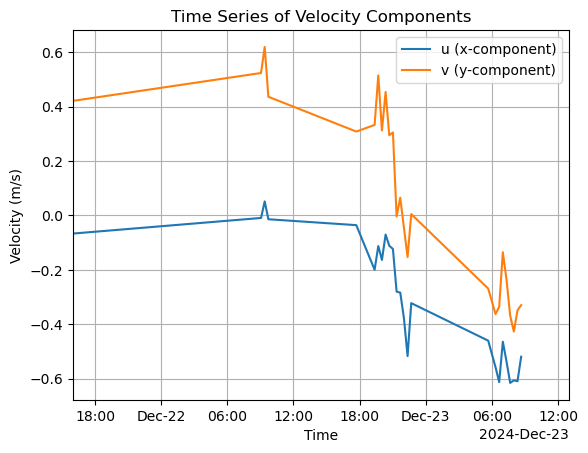

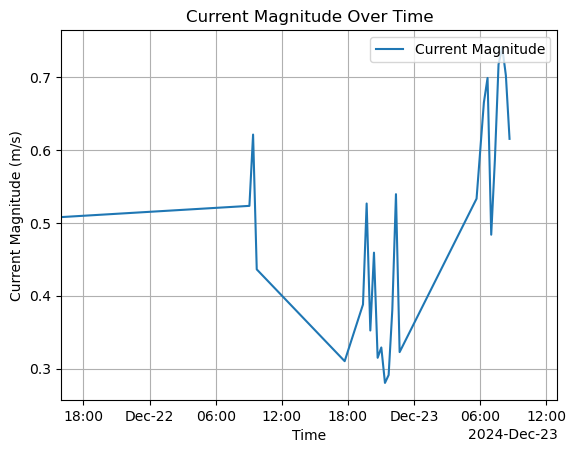

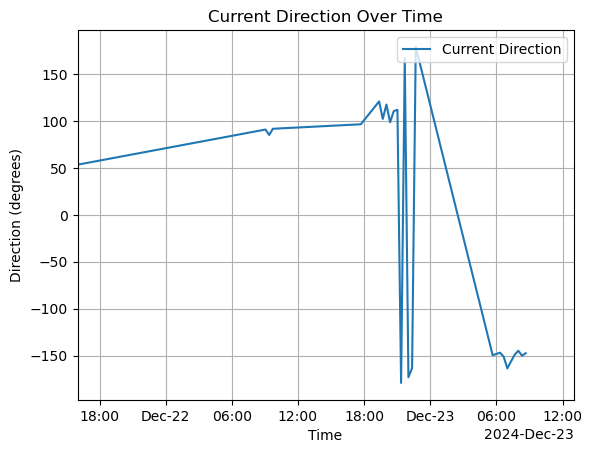

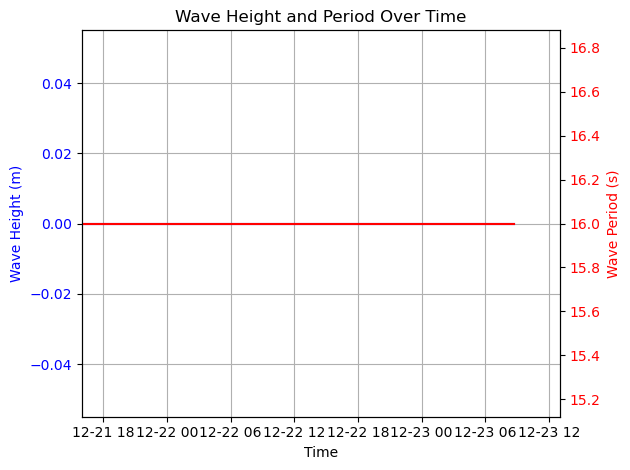

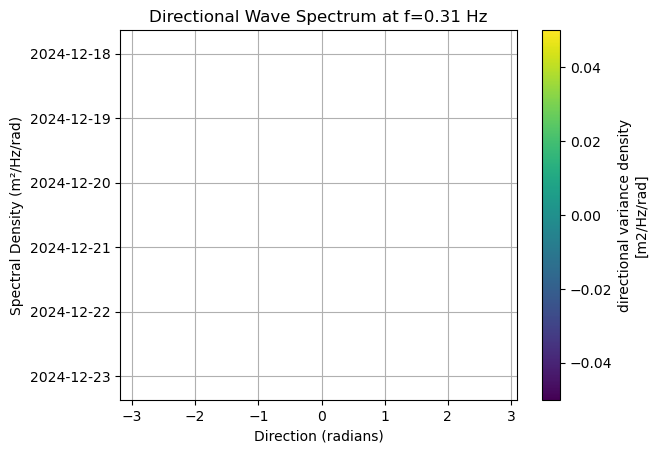

C:\Users\Daan Poppema\AppData\Local\Temp\ipykernel_23180\637205865.py:100: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 26, using nperseg = 26
  f, Pxx = welch(ds['vy'].mean(dim='f'), fs=fs, nperseg=256)


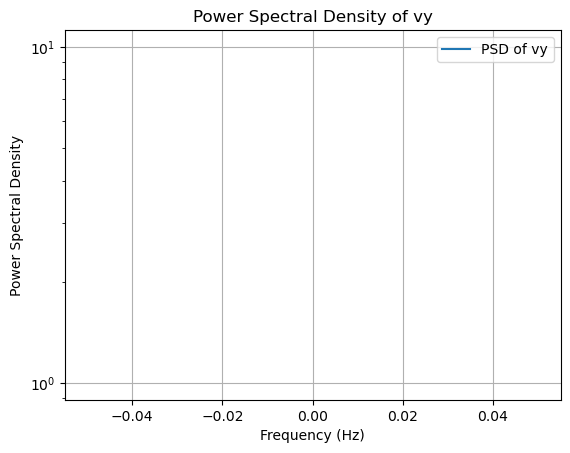

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the tailored NetCDF file
# ncOutFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\ADV\tailored\vec1_pilot_tailored.nc"
# ds = xr.open_dataset(ncOutFile)
 
# Print the dataset structure to understand what variables are available
# ds

# # Set x-axis limits using specific date stamps
# start_time = pd.Timestamp("2024-12-21T16:00:00")
# end_time = pd.Timestamp("2024-12-23T13:00:00")
# plt.xlim(start_time, end_time)

# 1. Time Series of Velocity Components (u_mean, v_mean)
if 'u_mean' in ds and 'v_mean' in ds:
    ds['u_mean'].plot(label="u (x-component)")
    ds['v_mean'].plot(label="v (y-component)")
    plt.title("Time Series of Velocity Components")
    plt.xlabel("Time")
    plt.ylabel("Velocity (m/s)")
    plt.legend(loc='upper right')
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    plt.xlim(start_time, end_time)
    plt.grid()
    plt.show()

# 2. Current Magnitude and Direction
if 'u_mean' in ds and 'v_mean' in ds:
    current_magnitude = np.sqrt(ds['u_mean']**2 + ds['v_mean']**2)
    current_magnitude.plot(label="Current Magnitude")
    plt.title("Current Magnitude Over Time")
    plt.xlabel("Time")
    plt.ylabel("Current Magnitude (m/s)")
    plt.legend(loc='upper right')
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    plt.xlim(start_time, end_time)
    plt.grid()
    plt.show()

    if 'cur_dir' in ds:
        ds['cur_dir'].plot(label="Current Direction")
        plt.title("Current Direction Over Time")
        plt.xlabel("Time")
        plt.ylabel("Direction (degrees)")
        plt.legend(loc='upper right')
        start_time = pd.Timestamp("2024-12-21T16:00:00")
        end_time = pd.Timestamp("2024-12-23T13:00:00")
        plt.xlim(start_time, end_time)
        plt.grid()
        plt.show()

# 3. Wave Height (Hm0) and Wave Period (Tp)
if 'Hm0' in ds and 'Tp' in ds:
    fig, ax1 = plt.subplots()

    # Plot Hm0 on the primary y-axis
    ax1.plot(ds['t'], ds['Hm0'], label="Hm0 (Wave Height)", color='b')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Wave Height (m)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot Tp on the secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(ds['t'], ds['Tp'], label="Tp (Wave Period)", color='r')
    ax2.set_ylabel("Wave Period (s)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title("Wave Height and Period Over Time")
    fig.tight_layout()
    start_time = pd.Timestamp("2024-12-21T16:00:00")
    end_time = pd.Timestamp("2024-12-23T13:00:00")
    ax1.set_xlim(start_time, end_time)
    ax2.set_xlim(start_time, end_time)
    ax1.grid()
    plt.show()

# 4. Directional Wave Spectrum (S)
if 'S' in ds:
    freq_idx = 10  # Select a specific frequency index for the example
    if freq_idx < len(ds['f']):
        ds['S'].isel(f=freq_idx).plot(x='theta', yincrease=False)
        plt.title(f"Directional Wave Spectrum at f={ds['f'][freq_idx].values:.2f} Hz")
        plt.xlabel("Direction (radians)")
        plt.ylabel("Spectral Density (m²/Hz/rad)")
        plt.grid()
        plt.show()

# 5. Power Spectral Density (vy)
if 'vy' in ds:
    from scipy.signal import welch

    # Compute PSD for 'vy' component
    fs = ds.sf.values if 'sf' in ds else 1.0  # Sampling frequency
    f, Pxx = welch(ds['vy'].mean(dim='f'), fs=fs, nperseg=256)

    plt.semilogy(f, Pxx, label="PSD of vy")
    plt.title("Power Spectral Density of vy")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

